In [1]:
import sys
sys.executable

'/Users/drewkilpatrick/Coding Projects/ercot-load-forecasting/venv/bin/python'

In [8]:
import pandas as pd

df_2025 = pd.read_excel("data/raw/Native_Load_2025.xlsx")
df_2025.head()


,Hour Ending,COAST,EAST,FWEST,NORTH,NCENT,SOUTH,SCENT,WEST,ERCOT
0,01/01/2025 01:00,10538.553193,1545.465863,7090.619810,1388.565588,11964.866264,3012.769998,6447.297871,1235.721317,43223.859905
1,01/01/2025 02:00,10477.912860,1553.994477,7040.460607,1390.392647,12064.919506,2962.803597,6382.650858,1249.397659,43122.532212
2,01/01/2025 03:00,10363.015361,1534.575620,7028.741719,1390.634577,12040.262276,2981.433181,6320.119991,1259.729121,42918.511847
3,01/01/2025 04:00,10259.984795,1548.084385,6992.734978,1402.423965,12055.424000,2970.761172,6277.132219,1274.238069,42780.783583
4,01/01/2025 05:00,10332.692971,1585.772017,7026.066195,1425.900669,12307.605237,2975.631819,6298.522746,1301.043053,43253.234707


In [9]:
df_2025.columns


Index(['Hour Ending', 'COAST', 'EAST', 'FWEST', 'NORTH', 'NCENT', 'SOUTH',
       'SCENT', 'WEST', 'ERCOT'],
      dtype='str')

In [10]:
df = df_2025.copy()

df = df.rename(columns={"Hour Ending": "dt", "ERCOT": "load_mw"})
df["dt"] = pd.to_datetime(df["dt"])
df = df.sort_values("dt").reset_index(drop=True)

df[["dt", "load_mw"]].head()


ValueError: time data "01/01/2025 24:00" doesn't match format "%m/%d/%Y %H:%M". You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [11]:
import pandas as pd

df = df_2025.copy()
df = df.rename(columns={"Hour Ending": "dt", "ERCOT": "load_mw"})

s = df["dt"].astype(str)

# split into date and time
date_part = s.str.slice(0, 10)      # "01/01/2025"
time_part = s.str.slice(11)         # "24:00" or "01:00", etc.

date_dt = pd.to_datetime(date_part, format="%m/%d/%Y", errors="raise")

# if time is 24:00, shift date +1 day and set hour=0
is_24 = time_part.eq("24:00")
date_dt = date_dt + pd.to_timedelta(is_24.astype(int), unit="D")

# build hour integer (24->0)
hour = pd.to_numeric(time_part.str.slice(0, 2), errors="coerce") % 24

df["dt"] = date_dt + pd.to_timedelta(hour, unit="h")

df = df.sort_values("dt").reset_index(drop=True)
df[["dt", "load_mw"]].head()


,dt,load_mw
0,2025-01-01 01:00:00,43223.859905
1,2025-01-01 02:00:00,43122.532212
2,2025-01-01 03:00:00,42918.511847
3,2025-01-01 04:00:00,42780.783583
4,2025-01-01 05:00:00,43253.234707


In [12]:
df["dt"].diff().value_counts().head(5)

dt
0 days 01:00:00    8757
0 days 02:00:00       1
0 days 00:00:00       1
Name: count, dtype: int64

In [13]:
df["load_mw"].isna().sum()

np.int64(0)

<Axes: title={'center': 'ERCOT Load (MW) - 2025'}, xlabel='dt'>

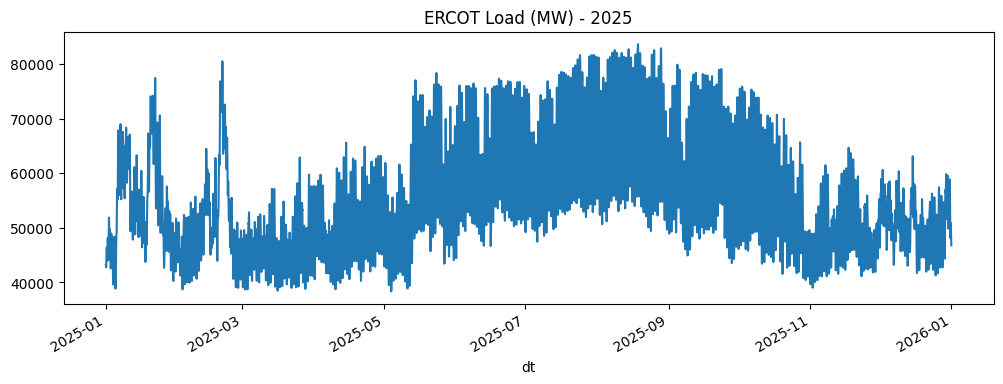

In [14]:
df.set_index("dt")["load_mw"].plot(figsize=(12,4), title="ERCOT Load (MW) - 2025")


In [16]:
import pandas as pd

def load_ercot_native_load(path: str) -> pd.DataFrame:
    df = pd.read_excel(path)
    df = df.rename(columns={"Hour Ending": "dt", "ERCOT": "load_mw"})
    
    s = df["dt"].astype(str)
    date_part = s.str.slice(0, 10)   # MM/DD/YYYY
    time_part = s.str.slice(11)      # HH:MM
    
    date_dt = pd.to_datetime(date_part, format="%m/%d/%Y", errors="raise")
    is_24 = time_part.eq("24:00")
    date_dt = date_dt + pd.to_timedelta(is_24.astype(int), unit="D")
    hour = pd.to_numeric(time_part.str.slice(0, 2), errors="coerce") % 24
    
    df["dt"] = date_dt + pd.to_timedelta(hour, unit="h")
    df = df.sort_values("dt").reset_index(drop=True)
    
    # keep only what we need for modeling
    out = df[["dt", "load_mw"]].copy()
    out["load_mw"] = pd.to_numeric(out["load_mw"], errors="coerce")
    return out


In [17]:
df_2023 = load_ercot_native_load("../data/raw/Native_Load_2023.xlsx")
df_2024 = load_ercot_native_load("../data/raw/Native_Load_2024.xlsx")
df_2025 = load_ercot_native_load("../data/raw/Native_Load_2025.xlsx")

df_all = pd.concat([df_2023, df_2024, df_2025], ignore_index=True)
df_all = df_all.drop_duplicates(subset=["dt"]).sort_values("dt").reset_index(drop=True)

df_all.head(), df_all.tail()


FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/Native_Load_2023.xlsx'

In [18]:
df_2023 = load_ercot_native_load("data/raw/Native_Load_2023.xlsx")
df_2024 = load_ercot_native_load("data/raw/Native_Load_2024.xlsx")
df_2025 = load_ercot_native_load("data/raw/Native_Load_2025.xlsx")

df_all = pd.concat([df_2023, df_2024, df_2025], ignore_index=True)
df_all = df_all.drop_duplicates(subset=["dt"]).sort_values("dt").reset_index(drop=True)

df_all.head(), df_all.tail()

(                   dt       load_mw
 0 2023-01-01 01:00:00  35609.173887
 1 2023-01-01 02:00:00  35012.298856
 2 2023-01-01 03:00:00  34369.582295
 3 2023-01-01 04:00:00  34000.730337
 4 2023-01-01 05:00:00  33865.078669,
                        dt       load_mw
 26296 2025-12-31 20:00:00  49868.701664
 26297 2025-12-31 21:00:00  49069.809445
 26298 2025-12-31 22:00:00  48256.977350
 26299 2025-12-31 23:00:00  47394.684164
 26300 2026-01-01 00:00:00  46810.796215)

In [19]:
df_all["dt"].min(), df_all["dt"].max(), len(df_all)

(Timestamp('2023-01-01 01:00:00'), Timestamp('2026-01-01 00:00:00'), 26301)

In [20]:
df_all["dt"].diff().value_counts().head(5)


dt
0 days 01:00:00    26297
0 days 02:00:00        3
Name: count, dtype: int64

In [21]:
import os

os.makedirs("../data/processed", exist_ok=True)
df_all.to_csv("../data/processed/ercot_load_hourly_2023_2025.csv", index=False)


In [22]:
df_all["dt"].min(), df_all["dt"].max(), df_all.shape


(Timestamp('2023-01-01 01:00:00'),
 Timestamp('2026-01-01 00:00:00'),
 (26301, 2))

In [23]:
df_all["dt"].diff().value_counts().head(10)


dt
0 days 01:00:00    26297
0 days 02:00:00        3
Name: count, dtype: int64

In [24]:
df_all["load_mw"].isna().sum()


np.int64(0)

In [25]:
import os
os.makedirs("../data/processed", exist_ok=True)
df_all.to_csv("../data/processed/ercot_load_hourly_2023_2025.csv", index=False)
